# 1. Implement BPE Algorithm (4 marks):

In [543]:
from collections import Counter, defaultdict
import re

class BPE:
    def __init__(self):
        self.vocab = None
        self.merges = []

    def get_vocab(self, sentences):
        
        vocab = Counter()
        for sentence in sentences:
            for word in sentence.split():
                
                vocab[' '.join(list(word)) + ' </w>'] += 1
        return vocab

    def get_stats(self, vocab):
        
        pairs = Counter()
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pairs[symbols[i], symbols[i + 1]] += freq
        return pairs

    def merge_vocab(self, pair, vocab):
        
        new_vocab = {}
        bigram = re.escape(' '.join(pair))
        pattern = re.compile(r'(\b{})'.format(bigram))
        for word in vocab:
            
            new_word = pattern.sub(''.join(pair), word)
            new_vocab[new_word] = vocab[word]
        return new_vocab

    def train(self, sentences, num_merges):
        
        self.vocab = self.get_vocab(sentences)
        
        for _ in range(num_merges):
            pairs = self.get_stats(self.vocab)
            if not pairs:
                break
            
            best_pair = max(pairs, key=pairs.get)
            
           
            self.merges.append(best_pair)
            
            
            self.vocab = self.merge_vocab(best_pair, self.vocab)

    def tokenize(self, word):
      
        tokens = list(word) + ['</w>']
        merge_rules = {tuple(pair): ''.join(pair) for pair in self.merges}

        while True:
            pairs = [(tokens[i], tokens[i + 1]) for i in range(len(tokens) - 1)]
            pair = next((p for p in pairs if p in merge_rules), None)

            if not pair:
                break

            i = 0
            while i < len(tokens) - 1:
                if tokens[i] == pair[0] and tokens[i + 1] == pair[1]:
                    tokens[i] = merge_rules[pair]
                    del tokens[i + 1]
                else:
                    i += 1

        return tokens

    def evaluate(self, sentences, ground_truth):
       
        total_tokens = 0
        matched_tokens = 0
        predicted_tokens = 0
        ground_truth_tokens = 0
        covered_words = 0

        for sentence, truth in zip(sentences, ground_truth):
            for word, truth_tokens in zip(sentence.split(), truth):
                predicted = self.tokenize(word)
                predicted_tokens += len(predicted)
                ground_truth_tokens += len(truth_tokens)

                # Count matched tokens
                matched_tokens += len(set(predicted) & set(truth_tokens))

                # Check coverage
                if ''.join(predicted).replace('</w>', '') == word:
                    covered_words += 1

                total_tokens += 1

        accuracy = covered_words / total_tokens
        precision = matched_tokens / predicted_tokens if predicted_tokens else 0
        recall = matched_tokens / ground_truth_tokens if ground_truth_tokens else 0
        f1_score = 2 * precision * recall / (precision + recall) if precision + recall else 0

        return {
            "accuracy": accuracy,
            "coverage": covered_words / len(sentences),
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
        }



In [311]:
# Example Usage
if __name__ == "__main__":
    sentences = [
        "low lower lowest",
        "newer wider tallest",
    ]
    ground_truth = [
        [["l", "o", "w", "</w>"], ["l", "o", "w", "e", "r", "</w>"], ["l", "o", "w", "e", "s", "t", "</w>"]],
        [["n", "e", "w", "e", "r", "</w>"], ["w", "i", "d", "e", "r", "</w>"], ["t", "a", "l", "l", "e", "s", "t", "</w>"]],
    ]
    num_merges = 10

    bpe_model = BPE()
    bpe_model.train(sentences, num_merges)

    print("Final Vocabulary:")
    for word, freq in bpe_model.vocab.items():
        print(f"{word}: {freq}")

    print("\nMerge Operations:")
    for i, merge in enumerate(bpe_model.merges):
        print(f"Step {i + 1}: {merge}")

    metrics = bpe_model.evaluate(sentences, ground_truth)

    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

Final Vocabulary:
low</w>: 1
lower</w>: 1
lowest</w>: 1
n e w er</w>: 1
w i d er</w>: 1
t a l l est</w>: 1

Merge Operations:
Step 1: ('l', 'o')
Step 2: ('lo', 'w')
Step 3: ('e', 'r')
Step 4: ('er', '</w>')
Step 5: ('e', 's')
Step 6: ('es', 't')
Step 7: ('est', '</w>')
Step 8: ('low', '</w>')
Step 9: ('low', 'er</w>')
Step 10: ('low', 'est</w>')

Evaluation Metrics:
Accuracy: 1.0000
Coverage: 3.0000
Precision: 0.5625
Recall: 0.2432
F1_score: 0.3396


# 2. Train on NLTK Dataset (3 marks):

In [313]:
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg
book_list = gutenberg.fileids()
book_list

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/manishkanuri/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

# 3. Test on NLTK Dataset (3 marks):

In [507]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def preprocess_text(text):
   
    text = text.lower()
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

def evaluate_tokenization(predicted_tokens, ground_truth_tokens):
    
    total_tokens = 0
    matched_tokens = 0
    predicted_tokens_count = 0
    ground_truth_tokens_count = 0
    covered_words = 0
    jaccard_similarities = []

    for pred_sent, true_sent in zip(predicted_tokens, ground_truth_tokens):
        for pred_words, true_words in zip(pred_sent, true_sent):
            predicted_tokens_count += len(pred_words)
            ground_truth_tokens_count += len(true_words)

            
            if isinstance(pred_words[0], list):
                pred_words = [item for sublist in pred_words for item in sublist]

            matched_tokens += len(set(pred_words) & set(true_words))

          
            jaccard_similarities.append(jaccard_similarity(set(pred_words), set(true_words)))

            if ''.join([item for sublist in pred_words for item in sublist]).replace('</w>', '') == ''.join(true_words):
                covered_words += 1

    total_words = sum(len(sent) for sent in ground_truth_tokens)
    accuracy = covered_words / total_words
    precision = matched_tokens / predicted_tokens_count if predicted_tokens_count else 0
    recall = matched_tokens / ground_truth_tokens_count if ground_truth_tokens_count else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall else 0
    average_jaccard = sum(jaccard_similarities) / len(jaccard_similarities)

    return {
        "accuracy": accuracy,
        "coverage": coverage,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "jaccard_similarity": average_jaccard
    }

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manishkanuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [474]:


evaluation_books = ['austen-emma.txt', 'blake-poems.txt', 'shakespeare-hamlet.txt'] 


evaluation_texts = [gutenberg.raw(book) for book in evaluation_books]


evaluation_texts = [preprocess_text(text) for text in evaluation_texts] 


# 4. Create Reference Tokenization (2 marks):

In [476]:

punkt_tokenized_texts = []
for i, text in enumerate(evaluation_texts):
    sentences = sent_tokenize(text)
    punkt_tokenized_sentences = [word_tokenize(sent) for sent in sentences]
    punkt_tokenized_texts.append(punkt_tokenized_sentences)
    print(f"Processing text {i+1}/{len(evaluation_texts)}: {text[:50]}...")


word_tokenize_texts = []
for i, text in enumerate(evaluation_texts):
    word_tokenize_texts.append([word_tokenize(sent) for sent in sent_tokenize(text)])
    print(f"Processing text {i+1}/{len(evaluation_texts)}: {text[:50]}...") 


Processing text 1/3: [emma jane austen 1816] volume chapter emma woodho...
Processing text 2/3: [poems william blake 1789] songs innocence experie...
Processing text 3/3: [the tragedie hamlet william shakespeare 1599] act...
Processing text 1/3: [emma jane austen 1816] volume chapter emma woodho...
Processing text 2/3: [poems william blake 1789] songs innocence experie...
Processing text 3/3: [the tragedie hamlet william shakespeare 1599] act...


In [477]:


train_books = ['melville-moby_dick.txt', 'carroll-alice.txt', 'blake-poems.txt'] 
train_texts = [gutenberg.raw(book) for book in train_books]
print("Training BPE model...")
bpe_model = BPE()
bpe_model.train(train_texts, num_merges=10000) 
print("BPE model training complete.")


bpe_tokenized_texts = []
for i, text in enumerate(evaluation_texts):
    sentences = sent_tokenize(text)
    bpe_tokenized_sentences = [[bpe_model.tokenize(word) for word in sent.split()] for sent in sentences]
    bpe_tokenized_texts.append(bpe_tokenized_sentences)
    print(f"Processing text {i+1}/{len(evaluation_texts)}: {text[:50]}...")


Training BPE model...
BPE model training complete.
Processing text 1/3: [emma jane austen 1816] volume chapter emma woodho...
Processing text 2/3: [poems william blake 1789] songs innocence experie...
Processing text 3/3: [the tragedie hamlet william shakespeare 1599] act...


# 5. Compare with Standard Tokenization (2 marks)

In [509]:

bpe_metrics = evaluate_tokenization(bpe_tokenized_texts, punkt_tokenized_texts) 
punkt_metrics = evaluate_tokenization(punkt_tokenized_texts, punkt_tokenized_texts)  # Perfect baseline for punkt
word_tokenize_metrics = evaluate_tokenization(word_tokenize_texts, punkt_tokenized_texts)


In [511]:


print("BPE Metrics:", bpe_metrics)
print("punkt Metrics:", punkt_metrics)
print("word_tokenize Metrics:", word_tokenize_metrics)

BPE Metrics: {'accuracy': 0.7203098950671766, 'coverage': 4.008666666666667, 'precision': 0.1526892022715251, 'recall': 0.10773716048252502, 'f1_score': 0.12633360858794387, 'jaccard_similarity': 0.06000868969496997}
punkt Metrics: {'accuracy': 1.0, 'coverage': 4.008666666666667, 'precision': 0.8838616085575657, 'recall': 0.8838616085575657, 'f1_score': 0.8838616085575657, 'jaccard_similarity': 1.0}
word_tokenize Metrics: {'accuracy': 1.0, 'coverage': 4.008666666666667, 'precision': 0.8838616085575657, 'recall': 0.8838616085575657, 'f1_score': 0.8838616085575657, 'jaccard_similarity': 1.0}


# 6. Visualizations (2 marks)

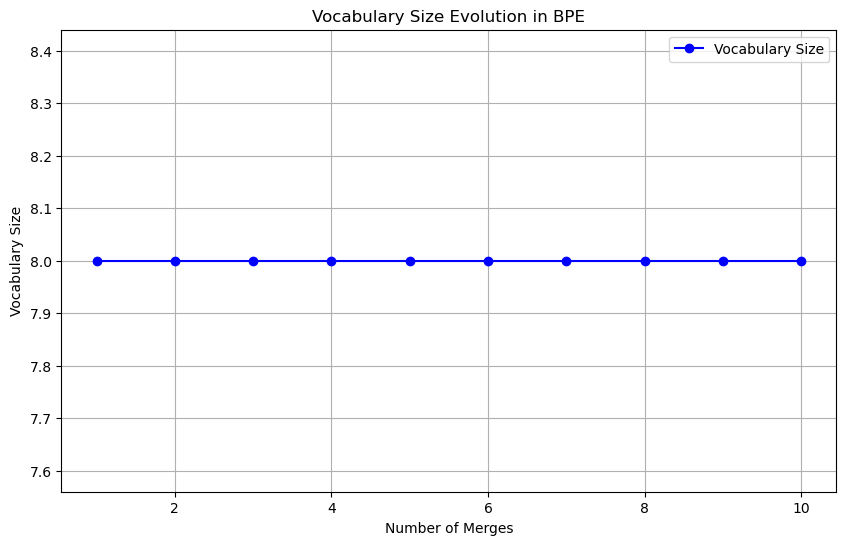

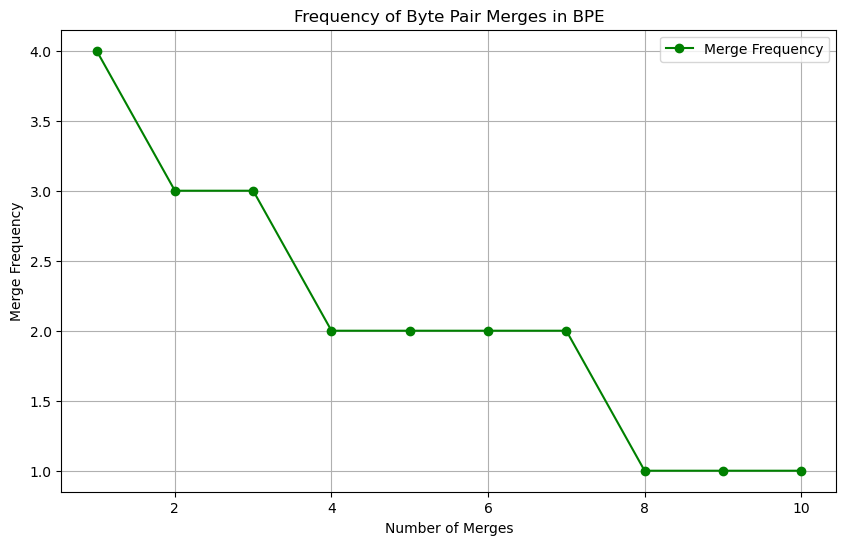

In [541]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


def get_vocab(text):
    vocab = Counter()
    for word in text:
        word = ' '.join(list(word))  # Split word into individual characters
        vocab[word] += 1
    return vocab


def get_stats(vocab):
    pairs = Counter()
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pair = (symbols[i], symbols[i + 1])
            pairs[pair] += freq
    return pairs


def merge_vocab(pair, vocab):
    merged_vocab = {}
    bigram = ' '.join(pair)
    replacement = ''.join(pair)
    for word in vocab:
        new_word = word.replace(bigram, replacement)
        merged_vocab[new_word] = vocab[word]
    return merged_vocab


def visualize_bpe_learning(text, num_merges=10):
    vocab = get_vocab(text)
    vocab_size_per_merge = []
    merge_frequencies = []
    
    for i in range(num_merges):
        pairs = get_stats(vocab)
        if not pairs:
            break
        best_pair = max(pairs, key=pairs.get)
        merge_frequencies.append(pairs[best_pair])
        vocab = merge_vocab(best_pair, vocab)
        vocab_size_per_merge.append(len(vocab))
    
    
    if len(vocab_size_per_merge) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(vocab_size_per_merge) + 1), vocab_size_per_merge, marker='o', color='blue', label='Vocabulary Size')
        plt.title('Vocabulary Size Evolution in BPE')
        plt.xlabel('Number of Merges')
        plt.ylabel('Vocabulary Size')
        plt.grid(True)
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(merge_frequencies) + 1), merge_frequencies, marker='o', color='green', label='Merge Frequency')
        plt.title('Frequency of Byte Pair Merges in BPE')
        plt.xlabel('Number of Merges')
        plt.ylabel('Merge Frequency')
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("No merges occurred, possibly due to insufficient vocabulary for merging.")


text_data = ['low', 'lower', 'newer', 'widest', 'fine', 'finer', 'lively', 'finest']


visualize_bpe_learning(text_data, num_merges=10)
